In [ ]:
!pip install open-spiel
!pip install tensorflow

In [7]:
import pyspiel
import numpy as np
from openspiel__cheat.cheat import *
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

# DQN vs DQN
Some experiments involving training DQN agents against each other.

In [3]:
hidden_layers_sizes = [32, 32]
replay_buffer_capacity = 2000
min_buffer_size_to_learn = 100
train_episodes = 200
loss_report_interval = 10
checkpoint_temp = "openspiel_checkpoint/model_%s_.chkpt"

In [13]:
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import dqn, tabular_qlearner, random_agent

def train_models(num_players, model_checkpoint):
    env = rl_environment.Environment(f"python_cheat(players={num_players})")

    num_players = env.num_players
    state_size = env.observation_spec()["info_state"][0]
    num_actions = env.action_spec()["num_actions"]
    loss = []

    with tf.Session() as sess:
        agents = []

        for i in range(num_players):
            agents.append(
                dqn.DQN(
                sess,
                player_id=i,
                state_representation_size=state_size,
                num_actions=num_actions,
                hidden_layers_sizes=hidden_layers_sizes,
                replay_buffer_capacity=replay_buffer_capacity,
                min_buffer_size_to_learn=min_buffer_size_to_learn
            )
            )

        sess.run(tf.global_variables_initializer())
        tf_saver = tf.train.Saver(tf.global_variables())

        for ep in range(train_episodes):
            if ep > 0:
                loss.append(tuple(agent.loss for agent in agents))
                if ep % loss_report_interval == 0:
                    curr_losses = ",".join(
                        "n/a" if curr_loss is None else f"{curr_loss:.3f}" for curr_loss in loss[-1]
                    )
                    print(f"[{ep}/{train_episodes}] DQN loss: {curr_losses}")
            time_step = env.reset()

            while not env.get_state.is_terminal() and not time_step.last():
                if env.get_state.is_chance_node():
                    outcomes_with_probs = env.get_state.chance_outcomes()
                    action_list, prob_list = zip(*outcomes_with_probs)
                    action = np.random.choice(action_list, p=prob_list)
                    env.get_state.apply_action(action)
                else:
                    actions = []
                    for player in range(num_players):
                        actions.append(agents[player].step(time_step).action)
                    time_step = env.step(actions)

            for agent in agents:
                agent.step(time_step)

        tf_saver.save(sess, model_checkpoint)
        print("Completed Training!")

    return agents, loss

def test_against_random_players(agent, player_no, num_players, model_checkpoint):
    env = rl_environment.Environment(f"python_cheat(players={num_players})")

    with tf.Session() as sess:
        tf_saver = tf.train.Saver()
        tf_saver.restore(sess, model_checkpoint)

        agent._session = sess

        eval_agents = [
            random_agent.RandomAgent(i, env.game.num_distinct_actions(), "Random") for i in range(num_players)
        ]
        eval_agents[player_no] = agent

        n_games = 200
        n_wins = 0
        is_evaluation = True

        for cur_episode in range(n_games):
            time_step = env.reset()
            curr = 0
            while not env.get_state.is_terminal() and not time_step.last():
                if env.get_state.is_chance_node():
                    outcomes_with_probs = env.get_state.chance_outcomes()
                    action_list, prob_list = zip(*outcomes_with_probs)
                    action = np.random.choice(action_list, p=prob_list)
                    env.get_state.apply_action(action)
                else:
                    curr += 1
                    actions = []
                    for player in range(len(eval_agents)):
                        actions.append(
                            eval_agents[player].step(time_step, is_evaluation=is_evaluation).action
                        )
                    time_step = env.step(actions)

            for agent in eval_agents:
                agent.step(time_step, is_evaluation=is_evaluation)

            if env.get_state.lead_player() == player_no:
                n_wins += 1

            print(f"Episode {cur_episode + 1}/{n_games}, Won: {n_wins} ({100 * n_wins / (cur_episode + 1):.2f}%)", end="\r")
        print("\nGames ended!")


## Two Players

In [5]:
# Two Player DQN vs DQN
p2_agents, p2_loss = train_models(2, checkpoint_temp.format(2))

[10/200] DQN loss: n/a,n/a
[20/200] DQN loss: 177.109,186.524
[30/200] DQN loss: 119.697,167.455
[40/200] DQN loss: 159.489,151.943
[50/200] DQN loss: 144.439,161.332
[60/200] DQN loss: 104.983,178.000
[70/200] DQN loss: 119.784,147.378
[80/200] DQN loss: 119.613,114.142
[90/200] DQN loss: 102.438,113.669
[100/200] DQN loss: 86.601,367.561
[110/200] DQN loss: 83.765,118.341
[120/200] DQN loss: 55.899,280.984
[130/200] DQN loss: 56.779,104.425
[140/200] DQN loss: 66.791,65.185
[150/200] DQN loss: 48.321,97.898
[160/200] DQN loss: 50.420,87.830
[170/200] DQN loss: 45.980,71.951
[180/200] DQN loss: 50.705,80.989
[190/200] DQN loss: 53.896,132.974
Completed Training!


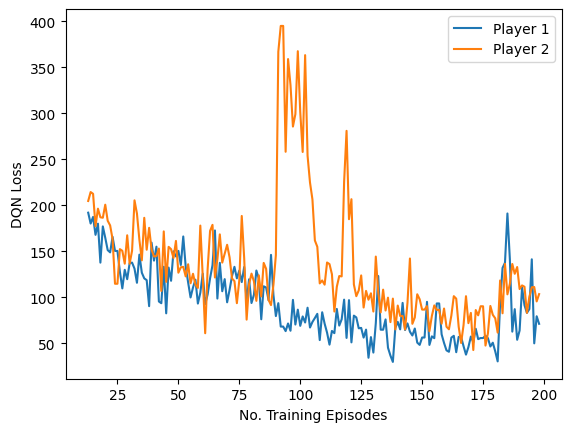

In [16]:
plt.plot(range(len(p2_loss)), p2_loss, label=["Player 1", "Player 2"])
plt.xlabel("No. Training Episodes")
plt.ylabel("DQN Loss")
plt.legend()
plt.show()

In [11]:
test_against_random_players(p2_agents[0], 0, 2, checkpoint_temp.format(2))

Episode 200/200, Won: 200 (100.00%)
Games ended!


In [14]:
test_against_random_players(p2_agents[1], 1, 2, checkpoint_temp.format(2))

Episode 200/200, Won: 200 (100.00%)
Games ended!


In [ ]:
# Interactive
first_player = False
player = 0 if first_player else 1

is_evaluation = True

model_checkpoint = checkpoint_temp.format(2)
env = rl_environment.Environment(f"python_cheat(players={num_players})")

with tf.Session() as sess:
    tf_saver = tf.train.Saver()
    tf_saver.restore(sess, model_checkpoint)

    opponent = p2_agents[1 - player]
    opponent._session = sess

    from collections import Counter

    time_step = env.reset()
    transcript = []

    while not env.get_state.is_terminal() and not time_step.last():
        if env.get_state.is_chance_node():
            outcomes_with_probs = state.chance_outcomes()
            action_list, prob_list = zip(*outcomes_with_probs)
            action = np.random.choice(action_list, p=prob_list)
            state.apply_action(action)
        else:
            actions = []

            state = env.get_state

            actions.append(opponent.step(time_step, is_evaluation=is_evaluation).action)

            last_claim_action = state.last_claim_action

            if last_claim_action == -1:
                last_put = "n/a"
            else:
                _, count, num = state._decode_play(last_claim_action)
                last_put = f"{count} x {num}s"

            player_legal_actions = state.legal_actions(player)

            possible_actions = []
            action_accuse = state._ENCODE_ACTION[Action.ACCUSE]
            action_pass = state._ENCODE_ACTION[Action.PASS]

            if action_accuse in player_legal_actions:
                possible_actions.append("accuse (a)")
            if action_pass in player_legal_actions:
                possible_actions.append("pass (p)")
            if any(i > 1 for i in player_legal_actions):
                possible_actions.append("claim (c [amount] [num] [c_1],...,[c_amount])")

            msg = "\n".join(
                (
                    f"Your deck: {state.hand_bits_to_nums(state.hands[player])}.",
                    f"Pile has {int.bit_count(int(state.pile))} cards.",
                    f"Last put on pile: {last_put}.",
                    f"Actions: {', '.join(possible_actions)}.",
                    "Next move: ",
                )
            )

            command = ""
            first_entry = True
            while True:
                if not first_entry:
                    print(f"Invalid move: {command}, try again.")
                first_entry = False

                command = input(msg)

                if not command:
                    continue
                if command == "a":
                    if action_accuse not in player_legal_actions:
                        continue
                    actions.append(action_accuse)
                    break
                if command == "p":
                    if action_pass not in player_legal_actions:
                        continue
                    actions.append(action_pass)
                    break

                args = command.split(" ")
                if (
                    len(args) != 4
                    or args[0] != "c"
                    or not args[1].isnumeric()
                    or not args[2].isnumeric()
                ):
                    continue
                _, _count, _num, _truth = args
                num, count = int(_num), int(_count)

                _cards_played = _truth.split(",")
                if len(_cards_played) != count or not all(
                    card.isnumeric() for card in _cards_played
                ) or num not in state._legal_next_number() or count > state._NUM_NUMBERS:
                    continue

                cards_played = map(int, _cards_played)
                counter = Counter(cards_played)
                card_masks = [
                    (
                        num,
                        sum(
                            1 << (state._NUM_NUMBERS * i + (num - 1))
                            for i in range(state._NUM_SUITES)
                        ),
                    )
                    for num in counter
                ]

                truth = 0
                insufficient_cards = False

                for num, mask in card_masks:
                    play = mask & state.hands[player]
                    num_available = int.bit_count(int(play))
                    num_played = counter[num]

                    if num_available < num_played:
                        insufficient_cards = True
                        break

                    if num_available == num_played:
                        truth += play
                        continue

                    rem_to_dispose = num_available - num_played
                    bits_traversed = 0

                    while rem_to_dispose > 0:
                        if play % 2 == 1:
                            rem_to_dispose -= 1
                        play >>= 1
                        bits_traversed += 1

                    play <<= bits_traversed
                    truth += play

                if insufficient_cards:
                    continue

                action = state._ENCODE_ACTION[state._encode_play(truth, count, num)]
                assert action in player_legal_actions
                actions.append(action)
                break

            if actions[0] == action_accuse:
                opponent_msg = "Opponent accuses!"
            elif actions[0] == action_pass:
                opponent_msg = "Opponent passes."
            else:
                _, count, num = state._decode_play(state._DECODE_ACTION[actions[0]])
                opponent_msg = f"Opponent claims {count} x {num}s."

            if actions[1] == action_accuse:
                player_msg = "You accuse!"
            elif actions[1] == action_pass:
                player_msg = "You pass."
            else:
                _, count, num = state._decode_play(state._DECODE_ACTION[actions[1]])
                player_msg = f"You claim {count} x {num}s."

            print("----")
            if first_player:
                print(player_msg, flush=True)
                print(opponent_msg, flush=True)
            else:
                print(opponent_msg, flush=True)
                print(player_msg, flush=True)

            if first_player:
                actions = actions[::-1]
            transcript.extend(state._action_to_string(i, actions[i]) for i in range(2))

            time_step = env.step(actions)

    opponent.step(time_step, is_evaluation=is_evaluation)

    print("----\nGame ended!")
    if env.get_state.lead_player() == player:
        print("You won!")
    else:
        print("You lost!")


## Three Players

In [17]:
# DQN vs DQN vs DQN
p3_agents, p3_loss = train_models(3, checkpoint_temp.format(3))

[10/200] DQN loss: 18.590,9.809,18.223
[20/200] DQN loss: 9.021,9.941,22.547
[30/200] DQN loss: 14.099,15.570,10.673
[40/200] DQN loss: 8.479,14.700,12.517
[50/200] DQN loss: 11.182,15.677,15.781
[60/200] DQN loss: 10.774,10.050,11.861
[70/200] DQN loss: 13.256,8.580,10.443
[80/200] DQN loss: 11.891,15.536,13.523
[90/200] DQN loss: 11.395,13.679,15.036
[100/200] DQN loss: 21.587,10.340,16.496
[110/200] DQN loss: 15.975,15.956,10.549
[120/200] DQN loss: 24.534,10.156,15.520
[130/200] DQN loss: 11.003,10.807,9.946
[140/200] DQN loss: 9.584,14.848,16.190
[150/200] DQN loss: 15.559,10.128,12.139
[160/200] DQN loss: 11.879,12.853,10.835
[170/200] DQN loss: 21.133,10.962,10.200
[180/200] DQN loss: 11.565,13.264,15.245
[190/200] DQN loss: 18.555,12.018,12.471
Completed Training!


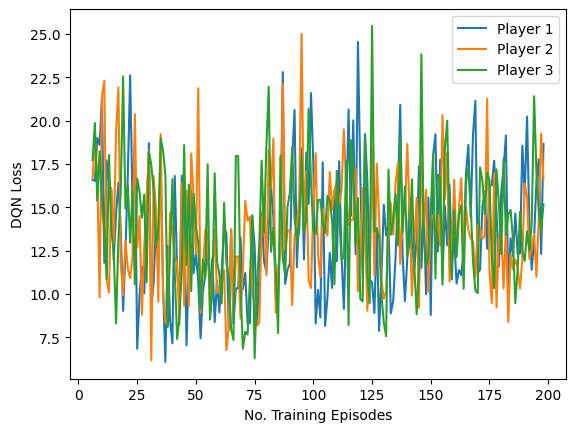

In [20]:
plt.plot(range(len(p3_loss)), p3_loss, label=["Player 1", "Player 2", "Player 3"])
plt.xlabel("No. Training Episodes")
plt.ylabel("DQN Loss")
plt.legend()
plt.show()

In [21]:
test_against_random_players(p3_agents[0], 0, 3, checkpoint_temp.format(3))

Episode 200/200, Won: 200 (100.00%)
Games ended!


In [22]:
test_against_random_players(p3_agents[1], 1, 3, checkpoint_temp.format(3))

Episode 200/200, Won: 200 (100.00%)
Games ended!


In [23]:
test_against_random_players(p3_agents[2], 2, 3, checkpoint_temp.format(3))

Episode 200/200, Won: 200 (100.00%)
Games ended!
